In [1]:
import numpy as np
import tensorflow as tf

2023-04-27 18:53:40.675886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [3]:
# Random seed setting
TRAIN_VAL_TEST_CLASS_SAMPLER_RANDOM_SEED = 123


class MetaDataset:
    def __init__(self, random_state=None):
        if random_state is None:
            self.random_state = np.random
        else:
            self.random_state = random_state

    def generate_meta_train_data(self, n_tasks: int, n_samples: int) -> list:
        raise NotImplementedError

    def generate_meta_test_data(self, n_tasks: int, n_samples_context: int, n_samples_test: int) -> list:
        raise NotImplementedError

# QAM data generating code

In [4]:
import numpy as np

class QAM16ToyMetaDataset():
    constellation = np.array([[-3, 3], [-1, 3], [1, 3], [3, 3],
                              [-3, 1], [-1, 1], [1, 1], [3, 1],
                              [-3, -1], [-1, -1], [1, -1], [3, -1],
                              [-3, -3], [-1, -3], [1, -3], [3, -3]])

    def __init__(self, random_state=None):
        self.random_state = np.random.RandomState(seed=random_state)

    def generate_meta_train_data(self, n_tasks=10, n_samples=100):
        """
        Generates meta training data (16 QAM constellation points)
        Args:
            n_tasks (int): number of tasks
            n_samples (int): number of samples per task
        Returns:
            List of 2-tuples [(x_train_1, y_train_1), ... (x_train_n, y_train_n)] wherein x_train is a stack
            of 2D coordinate arrays with shape (n_samples, 2) and y_train a stack of one-hot encodings with shape
            (n_samples, 16)
        """
        assert n_tasks > 0 or n_samples > 0

        task_tuples = []
        for _ in range(n_tasks):
            points = self.constellation[self.random_state.choice(16, size=n_samples)]
            one_hot = np.zeros((n_samples, 16))
            for i in range(n_samples):
                one_hot[i, np.where(np.all(points[i] == self.constellation, axis=1))[0][0]] = 1
            task_tuples.append((points, one_hot))

        assert len(task_tuples) == n_tasks
        assert all([x_train.shape[0] == y_train.shape[0] == n_samples for x_train, y_train in task_tuples])

        return task_tuples

    def generate_meta_test_data(self, n_tasks=10, n_samples_context=100, n_samples_test=500):
        """
        Generates meta test data (16 QAM constellation points)
        Args:
            n_tasks (int): number of tasks
            n_samples_context (int): number of context samples per task
            n_samples_test (int): number of test samples per task
        Returns:
            List of n_tasks 4-tuples [(x_context_1, y_context_1, x_test_1, y_test_1), ... ]
            wherein x_context and x_test are stacks of 2D coordinate arrays with shape (n_samples_context, 2) and
            (n_samples_test, 2) respectively, and y_context and y_test are stacks of one-hot encodings with shape
            (n_samples_context, 16) and (n_samples_test, 16) respectively.
        """
        assert n_tasks > 0 and n_samples_context > 0 and n_samples_test > 0

        task_tuples = []
        for _ in range(n_tasks):
            context_points = self.constellation[self.random_state.choice(16, size=n_samples_context)]
            context_one_hot = np.zeros((n_samples_context, 16))
            for i in range(n_samples_context):
                context_one_hot[i, np.where(np.all(context_points[i] == self.constellation, axis=1))[0][0]] = 1

            test_points = self.constellation[self.random_state.choice(16, size=n_samples_test)]
            test_one_hot = np.zeros((n_samples_test, 16))
            for i in range(n_samples_test):
                test_one_hot[i, np.where(np.all(test_points[i] == self.constellation, axis=1))[0][0]] = 1

            task_tuples.append((context_points, context_one_hot, test_points, test_one_hot))

        assert len(task_tuples) == n_tasks
        assert all([x_context.shape[0] == y_context.shape[0] == n_samples_context for x_context, y_context, x_test, y_test in task_tuples])
        assert all([x_test.shape[0] == y_test.shape[0] == n_samples_test for x_context, y_context, x_test, y_test in task_tuples])

        return task_tuples

In [5]:
env = QAM16ToyMetaDataset()
meta_train_data = env.generate_meta_train_data(n_tasks=5, n_samples=50)
meta_test_data = env.generate_meta_test_data(n_tasks=5, n_samples_context=5, n_samples_test=5)

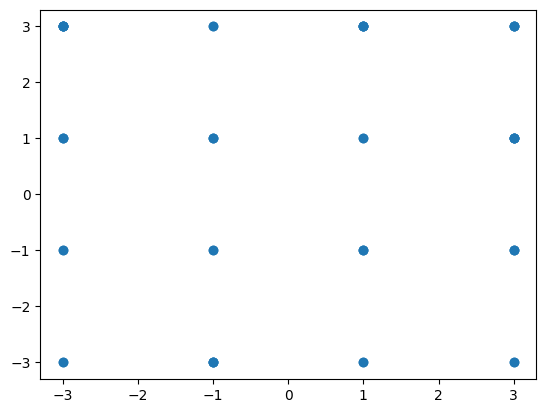

In [6]:
import matplotlib.pyplot as plt

qam16_dataset = QAM16ToyMetaDataset(random_state=42)
x_train, y_train = meta_train_data[0]
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

## BNN for classification

In [9]:
from pacoh_nn.bnn import BayesianNeuralNetwork_classification_SVGD


x_context, y_context, x_test, y_test = meta_test_data[0]

# setting up and fitting the BNN
bnn = BayesianNeuralNetwork_classification_SVGD(x_context, y_context, num_classes =16, hidden_layer_sizes=(64, 64, 64, 64), prior_weight=0.001, bandwidth=1000.0)
bnn.fit(x_val=x_test, y_val=y_test, num_iter_fit=500, log_period=500)

  0%|                                                   | 0/500 [00:02<?, ?it/s]


ValueError: in user code:

    File "/Users/klemens/Desktop/III_essy_coding/Experiment2_PACOH_NN/pacoh_nn/bnn/bnn_classification_svgd.py", line 120, in step  *
        score = tape.gradient(post_log_prob, self.particles)  # (k, n)
    File "/Users/klemens/Desktop/III_essy_coding/Experiment2_PACOH_NN/pacoh_nn/modules/batched_model.py", line 48, in concat_and_vectorize_grads  *
        return tf.reshape(vectorized_gradients, self._parameters_shape)

    ValueError: Cannot reshape a tensor with 137120 elements to shape [10,13728] (137280 elements) for '{{node Reshape_100}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](concat, Reshape_100/shape)' with input shapes: [137120,1], [2] and with input tensors computed as partial shapes: input[1] = [10,13728].


In [8]:
from pacoh_nn.pacoh_nn_classification import PACOH_NN_Classification
pacoh_model = PACOH_NN_Classification(meta_train_data, random_seed=22, num_classes= 16, 
                                      num_iter_meta_train=2000, num_iter_meta_test=2000,
                                  learn_likelihood=False, hyper_prior_weight=1e-4, lr=2e-5)



pacoh_model.meta_fit(meta_test_data[:10], eval_period=1000, log_period=500)

Start meta-training -------------------- 

Iter 0/2000 - Time 47.54 sec - Train-Loss: -5.16210

Iter 500/2000 - Time 12.97 sec - Train-Loss: -4.10003
	Start meta-test posterior inference in 1 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
(15, 5, 16)
tf.Tensor(
[[[-6.3561897e+09  2.0766680e+07 -6.4360448e+09 ... -6.3309537e+09
    6.2573082e+09 -6.4260132e+09]
  [-2.2477676e+09  7.3438070e+06 -2.2760064e+09 ... -2.2388426e+09
    2.2127992e+09 -2.2724595e+09]
  [-1.3774059e+07  4.5001984e+04 -1.3947107e+07 ... -1.3719370e+07
    1.3559779e+07 -1.3925367e+07]
  [-4.2531210e+08  1.3895640e+06 -4.3065555e+08 ... -4.2362342e+08
    4.1869565e+08 -4.2998426e+08]
  [-1.3774059e+07  4.5001984e+04 -1.3947107e+07 ... -1.3719370e+07
    1.3559779e+07 -1.3925367e+07]]

 [[-6.3188685e+09  2.1166890e+07 -6.3828669e+09 ... -6.2582031e+09
    6.1803172e+09 -6.3375933e+09]
  [-2.2531679e+09  7.5476440e+06 -2.2759882e+09 ... -2.2315359e+09
    2.2037637e+09 -2.2598449e+09]
  [

ValueError: components[0] batch shape must be compatible with cat shape and other component batch shapes ((5,) vs ())